### Importing Libraries:

In [3]:
import zipline

In [4]:
import pandas as pd
import pandas_datareader as web
import urllib.request
import zipfile
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import plotly
import matplotlib.pyplot as plt
import chart_studio
import cufflinks

In [189]:
import sklearn
from sklearn.decomposition import PCA
from scipy.optimize import minimize

### Download stock data:

In [287]:
# Define the stock names and the time horizon:
tick = ['AMZN','AAPL','NFLX','FB','MSFT','GOOG','TSLA','PEP','MCD','COST','C','MS','BA','AX','GE']
start_date = '2014-01-01'
end_date = '2020-12-31'

In [288]:
# Get the price data from Yahoo:
price_data = web.get_data_yahoo(tick,start=start_date,end=end_date)['Adj Close']

In [289]:
np.shape(price_data)

(1763, 15)

In [290]:
price_data.head()

Symbols,AAPL,AMZN,AX,BA,C,COST,FB,GE,GOOG,MCD,MS,MSFT,NFLX,PEP,TSLA
Date,,,,,,,,,,,,,,,
2014-01-02,17.598297,397.970001,18.987499,116.807953,46.111034,99.024254,54.709999,22.316345,554.481689,79.163460,26.571898,32.057323,51.831429,66.942528,30.020000
2014-01-03,17.211735,396.440002,18.985001,117.619873,47.107887,98.587143,54.560001,22.300112,550.436829,79.270203,26.982931,31.841665,51.871429,67.056679,29.912001
2014-01-06,17.305593,393.630005,18.892500,118.295074,47.469578,97.839096,57.200001,22.121578,556.573853,78.703659,27.077129,31.168766,51.367142,67.089302,29.400000
2014-01-07,17.181829,398.029999,18.895000,120.089874,47.795975,97.385201,57.919998,22.145929,567.303589,79.138802,26.991495,31.410315,48.500000,68.067757,29.872000
2014-01-08,17.290642,401.920013,19.587500,120.354836,48.351753,95.863838,58.230000,22.081011,568.484192,78.342339,27.025749,30.849575,48.712856,67.872078,30.256001


In [291]:
#Calculate stock returns:
return_data = price_data.pct_change()[1:]
return_data.head()

Symbols,AAPL,AMZN,AX,BA,C,COST,FB,GE,GOOG,MCD,MS,MSFT,NFLX,PEP,TSLA
Date,,,,,,,,,,,,,,,
2014-01-03,-0.021966,-0.003845,-0.000132,0.006951,0.021619,-0.004414,-0.002742,-0.000727,-0.007295,0.001348,0.015469,-0.006727,0.000772,0.001705,-0.003598
2014-01-06,0.005453,-0.007088,-0.004872,0.005741,0.007678,-0.007588,0.048387,-0.008006,0.011149,-0.007147,0.003491,-0.021133,-0.009722,0.000487,-0.017117
2014-01-07,-0.007152,0.011178,0.000132,0.015172,0.006876,-0.004639,0.012587,0.001101,0.019278,0.005529,-0.003163,0.007750,-0.055817,0.014584,0.016054
2014-01-08,0.006333,0.009773,0.036650,0.002206,0.011628,-0.015622,0.005352,-0.002931,0.002081,-0.010064,0.001269,-0.017852,0.004389,-0.002875,0.012855
2014-01-09,-0.012770,-0.002264,0.026165,0.009303,0.007115,0.039105,-0.017345,0.000367,-0.009630,0.000524,-0.000317,-0.006432,-0.011555,-0.004686,-0.024788


In [292]:
# Splitting the data into training and testing datasets:
training_return_data = return_data[return_data.index<'2020-01-01']
testing_return_data = return_data[return_data.index>='2020-01-01']
print("training length:",len(training_return_data),"testing length:",len(testing_return_data))

training length: 1509 testing length: 253


### Model - 1: Building portfolio based on statistical factors:

In [293]:
pca = PCA(n_components = 6)
pca.fit(training_return_data)
print(pca.explained_variance_ratio_)

[0.37963336 0.1314557  0.11619104 0.08154328 0.06151826 0.04214897]


In [294]:
# Factor loadings matrix:
Factor_Loadings = np.transpose(pca.components_)
np.shape(Factor_Loadings)

(15, 6)

In [295]:
# Factor returns vector:
factor_returns = pca.fit_transform(training_return_data)
np.shape(factor_returns)

(1509, 6)

In [296]:
# Factor covariance matrix:
cov_factor = np.cov(np.transpose(factor_returns))
np.shape(cov_factor)

(6, 6)

In [297]:
# mu:
mu = pca.mean_

In [298]:
# Constructing the matrix D:
reconstructed_returns = np.matmul(factor_returns,np.transpose(Factor_Loadings))+np.transpose(mu)
unexplained_returns = training_return_data - reconstructed_returns
unexplained_variance = np.diag(np.cov(np.transpose(unexplained_returns)))
D = np.diag(unexplained_variance)

#### Optimization framework for model-1:

In [299]:
# Risk level will be the hyperparameter.
risk_level = 0.0001

In [300]:
# Vector of 1's equal in length to r
e = np.ones(15)

In [301]:
# Randomly assigned weights:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [302]:
# Set initial weight values:
weights = rand_weights(15).reshape(15,1)
factor_weights = np.zeros(6).reshape(6,1)
variables = np.concatenate([weights,factor_weights])

In [303]:
# Objective function:
def objective(variables):
    return -np.matmul(np.transpose(mu),variables[0:15])

In [304]:
# Define Constraints
const = ({'type' : 'ineq' , 'fun' : lambda variables: risk_level -  np.matmul(np.matmul(np.transpose(variables[15:]),cov_factor),variables[15:]) - np.matmul(np.matmul(np.transpose(variables[:15]),D),variables[:15])}, # returns - mu >= 0
         {'type' : 'eq' , 'fun' : lambda variables: np.dot(variables[:15],e) - 1},# sum(w) - 1 = 0
        {'type' : 'eq' , 'fun' : lambda variables: np.matmul(np.transpose(Factor_Loadings),variables[:15]) - variables[15:]})    


In [305]:
# Create Bounds
# Creates a tuple of tuples to pass to minimize
# to ensure all weights are betwen [0, 1]
bounds = []
for i in range(15):
    bounds.append((0,None))
for i in range(6):
    bounds.append((None,None))
bounds = tuple(bounds)

In [306]:
# Run optimization with SLSQP solver
solution = minimize(fun=objective, x0=variables, method='SLSQP',constraints=const,bounds=bounds)
w = solution.x.round(6)
weights_model_1 = w[:15]
print(weights_model_1)
print(weights_model_1.sum())

[0.127576 0.032511 0.053763 0.095643 0.       0.055395 0.092803 0.
 0.       0.124681 0.023672 0.128793 0.073042 0.128762 0.06336 ]
1.0000010000000001


In [307]:
#List of the stocks with non-negative weights:
print(list(training_return_data.columns[w[:15] != 0.0]))

['AAPL', 'AMZN', 'AX', 'BA', 'COST', 'FB', 'MCD', 'MS', 'MSFT', 'NFLX', 'PEP', 'TSLA']


In [322]:
testing_return_data.iloc[:,:15].head()

Symbols,AAPL,AMZN,AX,BA,C,COST,FB,GE,GOOG,MCD,MS,MSFT,NFLX,PEP,TSLA
Date,,,,,,,,,,,,,,,
2020-01-02,0.022816,0.027151,-0.007926,0.023207,0.016773,-0.008268,0.022071,0.068996,0.022700,0.016092,0.017997,0.018516,0.019285,-0.006219,0.028518
2020-01-03,-0.009722,-0.012139,-0.004328,-0.001680,-0.018836,0.000823,-0.005291,0.003353,-0.004907,-0.003536,-0.016142,-0.012452,-0.011855,-0.001399,0.029633
2020-01-06,0.007968,0.014886,-0.008693,0.002945,-0.003137,0.000274,0.018834,0.014202,0.024657,0.011245,-0.003516,0.002585,0.030469,0.003834,0.019255
2020-01-07,-0.004703,0.002092,-0.016863,0.010607,-0.008685,-0.001576,0.002164,-0.007414,-0.000624,0.001483,-0.001960,-0.009118,-0.015127,-0.015718,0.038801
2020-01-08,0.016086,-0.007809,0.005832,-0.017523,0.007618,0.011464,0.010138,-0.009129,0.007880,0.016187,0.012765,0.015928,0.025729,0.005149,0.049205


In [324]:
testing_return_data['portfolio_1_return'] = np.matmul(testing_return_data.iloc[:,:15],weights_model_1)

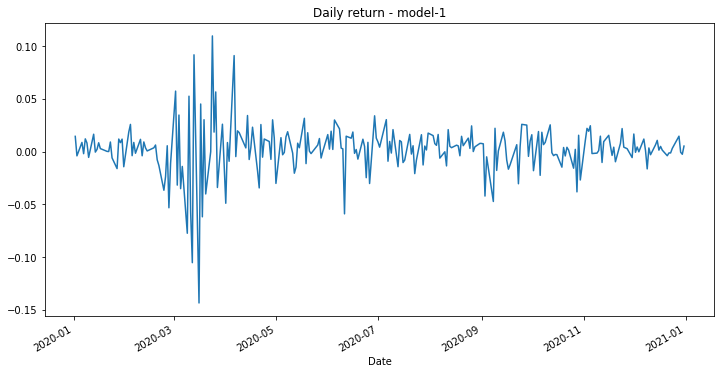

In [331]:
testing_return_data['portfolio_1_return'].plot(title = 'Daily return - model-1',figsize=(12, 6))

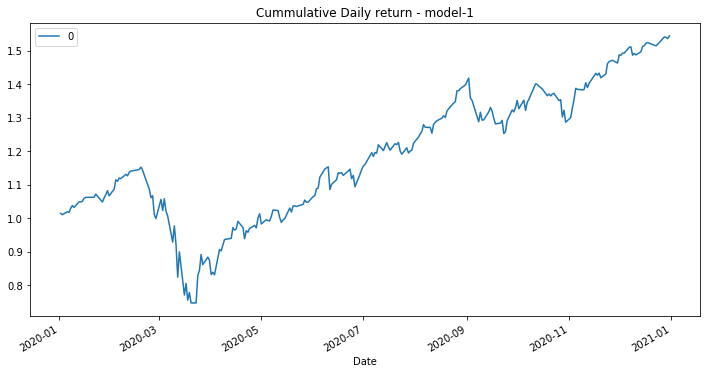

In [332]:
cum_datalist=[1+x for x in testing_return_data['portfolio_1_return']] 
cum_datalist=pd.DataFrame(cum_datalist, index=testing_return_data.index)
cum_datalist.cumprod().plot(title = 'Cummulative Daily return - model-1', figsize=(12, 6))

### Building portfolio based on Fama-French factor model:

In [335]:
def get_fama_french():
    # Web url
    ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    
    # Download the file and save it
    # We will name it fama_french.zip file
    
    urllib.request.urlretrieve(ff_url,'fama_french.zip')
    zip_file = zipfile.ZipFile('fama_french.zip', 'r')
    
    # Next we extract the file data
    
    zip_file.extractall()
    
    # Make sure you close the file after extraction
    
    zip_file.close()
    
    # Now open the CSV file
    
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, index_col = 0)
    # We want to find out the row with NULL value
    # We will skip these rows
    
    ff_row = ff_factors.isnull().any(1).nonzero()[0][0]
    
    # Read the csv file again with skipped rows
    ff_factors = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows = 3, nrows = ff_row, index_col = 0)
    
    # Format the date index
    ff_factors.index = pd.to_datetime(ff_factors.index, format= '%Y%m')
    
    # Format dates to end of month
    ff_factors.index = ff_factors.index + pd.offsets.MonthEnd()
    
    # Convert from percent to decimal
    ff_factors = ff_factors.apply(lambda x: x/ 100)
    return ff_factors

In [336]:
ff_data = get_fama_french()
print(ff_data.tail())

            Mkt-RF     SMB     HML      RF
2020-09-30 -0.0363  0.0006 -0.0251  0.0001
2020-10-31 -0.0210  0.0444  0.0403  0.0001
2020-11-30  0.1247  0.0548  0.0211  0.0001
2020-12-31  0.0463  0.0481 -0.0136  0.0001
2021-01-31 -0.0004  0.0718  0.0285  0.0000


In [342]:
training_return_data_M = training_return_data.resample("M").last()
testing_return_data_M = testing_return_data.resample("M").last()
training_return_data_M.head()

Symbols,AAPL,AMZN,AX,BA,C,COST,FB,GE,GOOG,MCD,MS,MSFT,NFLX,PEP,TSLA
Date,,,,,,,,,,,,,,,
2014-01-31,0.001641,-0.109972,0.000847,-0.010037,-0.018012,-0.003282,0.024394,-0.014510,0.040145,0.003944,-0.015677,0.026587,0.011516,-0.008880,-0.007821
2014-02-28,-0.002710,0.005470,-0.013980,0.002800,-0.001232,0.004991,-0.006963,-0.001176,-0.002920,0.000736,0.014493,0.011886,-0.014594,0.012647,-0.030609
2014-03-31,-0.000223,-0.005676,-0.024460,0.008276,0.007407,0.000179,0.003833,0.000386,-0.005393,0.008124,0.008411,0.017122,-0.019060,0.006631,-0.018458
2014-04-30,-0.003782,0.012484,0.016776,0.005064,-0.005191,0.002426,0.028031,0.004858,-0.001971,-0.001182,0.013434,-0.002715,0.006784,0.001516,0.004688
2014-05-31,-0.003746,-0.003920,-0.020650,0.000814,0.006134,0.016471,-0.008303,0.001870,-0.000339,0.000888,-0.008673,0.014873,0.006334,0.006839,-0.011748


In [343]:
# Merging the data
all_data = pd.merge(pd.DataFrame(training_return_data_M),ff_data, how = 'inner', left_index= True, right_index= True)
# Rename the columns

In [344]:

all_data.head()



,AAPL,AMZN,AX,BA,C,COST,FB,GE,GOOG,MCD,MS,MSFT,NFLX,PEP,TSLA,Mkt-RF,SMB,HML,RF
2014-01-31,0.001641,-0.109972,0.000847,-0.010037,-0.018012,-0.003282,0.024394,-0.014510,0.040145,0.003944,-0.015677,0.026587,0.011516,-0.008880,-0.007821,-0.0332,0.0087,-0.0202,0.0
2014-02-28,-0.002710,0.005470,-0.013980,0.002800,-0.001232,0.004991,-0.006963,-0.001176,-0.002920,0.000736,0.014493,0.011886,-0.014594,0.012647,-0.030609,0.0465,0.0031,-0.0036,0.0
2014-03-31,-0.000223,-0.005676,-0.024460,0.008276,0.007407,0.000179,0.003833,0.000386,-0.005393,0.008124,0.008411,0.017122,-0.019060,0.006631,-0.018458,0.0043,-0.0185,0.0490,0.0
2014-04-30,-0.003782,0.012484,0.016776,0.005064,-0.005191,0.002426,0.028031,0.004858,-0.001971,-0.001182,0.013434,-0.002715,0.006784,0.001516,0.004688,-0.0019,-0.0421,0.0112,0.0
2014-05-31,-0.003746,-0.003920,-0.020650,0.000814,0.006134,0.016471,-0.008303,0.001870,-0.000339,0.000888,-0.008673,0.014873,0.006334,0.006839,-0.011748,0.0206,-0.0190,-0.0012,0.0


In [22]:
# Merging the data
all_data = pd.merge(pd.DataFrame(ret_data),ff_data, how = 'inner', left_index= True, right_index= True)
# Rename the columns
all_data.rename(columns={"Mkt-RF":"mkt_excess"}, inplace=True)
# Calculate the excess returns
all_data['port_excess'] = all_data['portfolio'] - all_data['RF']
print(all_data.tail())

            portfolio  mkt_excess     SMB     HML      RF  port_excess
2019-02-28   0.014938      0.0340  0.0212 -0.0271  0.0018     0.013138
2019-03-31   0.022077      0.0110 -0.0305 -0.0419  0.0019     0.020177
2019-04-30   0.048800      0.0396 -0.0175  0.0202  0.0021     0.046700
2019-05-31  -0.057208     -0.0694 -0.0118 -0.0228  0.0021    -0.059308
2019-06-30   0.066343      0.0693  0.0022 -0.0079  0.0018     0.064543
